In [1]:
# Import Statements
import numpy as np
import matplotlib.pyplot as plt
from math import log, exp, log10, copysign
from scipy.fft import fft, ifft, fftn, ifftn
import time, sys, os              # and load some utilities
import warnings
warnings.filterwarnings("ignore")
print('Python version', sys.version)

Python version 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]


In [2]:
# use higher resolution svg graphics instead of png:
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf')
set_matplotlib_formats('svg')

# adjust plotting style defaults:

# default figure size okay if notebook is zoomed for class presentation:
#plt.style.use('default')
plt.rcParams["figure.figsize"] = [6.4, 4.8] # default
#plt.rcParams["figure.figsize"] = [8.0, 6.0]
plt.rcParams['font.size'] = 14  # default is about 12.
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams["axes.grid"] = False


# 2D Case

In [ ]:
global n_ghost
n_ghost = 3

In [ ]:
# Returns omega after applying doubly periodic B.C.
def apply_bc(omega):

  # Left Right (x)
  for j in range(n_ghost):
    omega[:,j] = omega[:, -2*n_ghost+j]
    omega[:, -n_ghost+j] = omega[:, n_ghost+j]

  # Up Down (y)
  for i in range(n_ghost):
      omega[i,:] = omega[-2*n_ghost+i,:]
      omega[-n_ghost+i,:] = omega[n_ghost+i,:]

  return omega

In [ ]:
# Returns stream function psi by a poisson solver
def poisson_solver(omega, Nx, Ny, dx, dy):
   
  kx = 2*np.pi*np.fft.fftfreq(Nx)/dx
  ky = 2*np.pi*np.fft.fftfreq(Ny)/dy
  
  # Tile arrays to make them match matrix dimensions
  kxhat = np.tile(kx,(len(ky),1)).transpose()
  kyhat = np.tile(ky,(len(kx),1))

  # Compute FFT
  omega_tilde = np.fft.fft2(-omega)

  # Handle 0's and then IFFT
  psi_k_tilde = -omega_tilde/(kxhat**2 + kyhat**2)
  psi_k_tilde[0,0] = -omega_tilde[0,0]
  psi_k = np.fft.ifft2(psi_k_tilde)

  return psi_k

In [ ]:
# Returns velocity from omega by using psi from the poisson solver
def velocity(omega, Nx, Ny, dx, dy):
  psi = np.real(poisson_solver(omega, Nx, Ny, dx, dy))
  v = np.zeros((len(psi), len(psi), 2))
  v[n_ghost:-n_ghost,n_ghost:-n_ghost, 0] = (psi[n_ghost:-n_ghost, n_ghost+1:-n_ghost+1] - psi[n_ghost:-n_ghost, n_ghost-1:-n_ghost-1])/(2*dx)
  v[n_ghost:-n_ghost,n_ghost:-n_ghost,1] = -(psi[n_ghost+1:-n_ghost+1,n_ghost:-n_ghost] - psi[n_ghost-1:-n_ghost-1,n_ghost:-n_ghost])/(2*dy) 
  return v

In [ ]:
def finite_vol(omega, v, dx, dy, dt):
  C4 = 1
  viscosity = 0.0
  vmax = np.abs(np.max(v))

  # Velocity at cell edges
  vxplushalf = (1/2)*(v[n_ghost:-n_ghost,n_ghost:-n_ghost,0]+v[n_ghost+1:-n_ghost+1,n_ghost:-n_ghost,0])
  vxminushalf = (1/2)*(v[n_ghost-1:-n_ghost-1,n_ghost:-n_ghost,0]+v[n_ghost:-n_ghost,n_ghost:-n_ghost,0])
  vyplushalf = (1/2)*(v[n_ghost:-n_ghost,n_ghost:-n_ghost,1]+v[n_ghost:-n_ghost, n_ghost+1:-n_ghost+1,1])
  vyminushalf = (1/2)*(v[n_ghost:-n_ghost,n_ghost-1:-n_ghost-1,1]+v[n_ghost:-n_ghost,n_ghost:-n_ghost,1])

  # Vorticities at cell edges
  omegaxplushalf = (7/12)*(omega[n_ghost+1:-n_ghost+1,n_ghost:-n_ghost]+omega[n_ghost:-n_ghost,n_ghost:-n_ghost]) - (1/12)*(omega[n_ghost-1:-n_ghost-1,n_ghost:-n_ghost]+omega[n_ghost+2:-n_ghost+2,n_ghost:-n_ghost])
  omegaxminushalf = (7/12)*(omega[n_ghost:-n_ghost,n_ghost:-n_ghost]+omega[n_ghost-1:-n_ghost-1,n_ghost:-n_ghost]) - (1/12)*(omega[n_ghost-2:-n_ghost-2, n_ghost:-n_ghost]+omega[n_ghost+1:-n_ghost+1,n_ghost:-n_ghost])
  omegayplushalf = (7/12)*(omega[n_ghost:-n_ghost,n_ghost+1:-n_ghost+1]+omega[n_ghost:-n_ghost,n_ghost:-n_ghost]) - (1/12)*(omega[n_ghost:-n_ghost,n_ghost-1:-n_ghost-1]+omega[n_ghost:-n_ghost,n_ghost+2:-n_ghost+2])
  omegayminushalf = (7/12)*(omega[n_ghost:-n_ghost,n_ghost:-n_ghost]+omega[n_ghost:-n_ghost,n_ghost-1:-n_ghost-1]) - (1/12)*(omega[n_ghost:-n_ghost,n_ghost-2:-n_ghost-2]+omega[n_ghost:-n_ghost,n_ghost+1:-n_ghost+1])

  # Fluxes at cell edges
  Fxplushalf = vxplushalf*omegaxplushalf - (C4*vmax*dx/48)*((3/12)*(omega[n_ghost+1:-n_ghost+1,n_ghost:-n_ghost]-omega[n_ghost:-n_ghost,n_ghost:-n_ghost]) - (1/12)*(omega[n_ghost+2:-n_ghost+2,n_ghost:-n_ghost]-omega[n_ghost-1:-n_ghost-1,n_ghost:-n_ghost]))
  Fxminushalf = vxminushalf*omegaxminushalf - (C4*vmax*dx/48)*((3/12)*(omega[n_ghost:-n_ghost,n_ghost:-n_ghost]-omega[n_ghost-1:-n_ghost-1,n_ghost:-n_ghost]) - (1/12)*(omega[n_ghost+1:-n_ghost+1,n_ghost:-n_ghost]-omega[n_ghost-2:-n_ghost-2,n_ghost:-n_ghost]))
  Fyplushalf = vyplushalf*omegayplushalf - (C4*vmax*dx/48)*((3/12)*(omega[n_ghost:-n_ghost,n_ghost+1:-n_ghost+1]-omega[n_ghost:-n_ghost,n_ghost:-n_ghost]) - (1/12)*(omega[n_ghost:-n_ghost,n_ghost+2:-n_ghost+2]-omega[n_ghost:-n_ghost,n_ghost-1:-n_ghost-1]))
  Fyminushalf = vyminushalf*omegayminushalf - (C4*vmax*dx/48)*((3/12)*(omega[n_ghost:-n_ghost,n_ghost:-n_ghost]-omega[n_ghost:-n_ghost,n_ghost-1:-n_ghost-1]) - (1/12)*(omega[n_ghost:-n_ghost,n_ghost+1:-n_ghost+1]-omega[n_ghost:-n_ghost,n_ghost-2:-n_ghost-2]))

  # Laplacian of vorticity
  second_der_x = (1/(dx**2))*(omega[n_ghost+1:-n_ghost+1,n_ghost:-n_ghost]-2*omega[n_ghost:-n_ghost,n_ghost:-n_ghost]+omega[n_ghost-1:-n_ghost-1,n_ghost:-n_ghost])
  second_der_y = (1/(dy**2))*(omega[n_ghost:-n_ghost,n_ghost+1:-n_ghost+1]-2*omega[n_ghost:-n_ghost,n_ghost:-n_ghost]+omega[n_ghost:-n_ghost,n_ghost-1:-n_ghost-1])

  # CHECK DIMENSIONS
  sol = dt*viscosity*(second_der_x + second_der_y) - (dt/dx)*(Fxplushalf - Fxminushalf + Fyplushalf - Fyminushalf)
  
  return sol

In [ ]:
# Returns 3rd order Runge-Kutta full time advance
def RK3_full_advance(f, omega, v, dx, dy, dt, Nx, Ny, t_end):
  t = 0.0
  omega0 = np.zeros_like(omega)
  omega1 = np.zeros_like(omega)
  omega2 = np.zeros_like(omega)
  omega_sol = omega

  while t <t_end:
    # STEP 1
    omega0 = omega_sol
    omega1[n_ghost:-n_ghost, n_ghost:-n_ghost] = omega0[n_ghost:-n_ghost, n_ghost:-n_ghost] + finite_vol(omega0, v, dx,dy, dt)
    omega1 = apply_bc(omega1)
    v = velocity(omega1, Nx, Ny, dx, dy) # Update v

    # STEP 2
    omega2[n_ghost:-n_ghost, n_ghost:-n_ghost] = (3/4)*omega0[n_ghost:-n_ghost, n_ghost:-n_ghost] + omega1[n_ghost:-n_ghost, n_ghost:-n_ghost]/4 + (1/4)*finite_vol(omega1,v,dx,dy,dt)
    omega2 = apply_bc(omega2)
    v = velocity(omega2, Nx, Ny, dx, dy) # Update v

    # STEP 3
    omega_sol[n_ghost:-n_ghost, n_ghost:-n_ghost] = omega0[n_ghost:-n_ghost, n_ghost:-n_ghost]/3 + 2*omega2[n_ghost:-n_ghost, n_ghost:-n_ghost]/3 + (2/3)*finite_vol(omega2,v,dx,dy,dt)
    omega_sol = apply_bc(omega_sol)
    v = velocity(omega_sol, Nx, Ny, dx, dy) # Update v

    t = t+dt
  
  return omega_sol

In [14]:
# Space grid
dx = 0.01
dy = 0.01
x_mesh,y_mesh = np.mgrid[-1-dx*n_ghost:1+dx*n_ghost+dx:dx, -1-dy*n_ghost:1+dy*n_ghost+dy:dy ]
Nx = len(x_mesh)
Ny = len(y_mesh)

cfl = 0.1
v=1
# time params
dt = cfl*dx/v
t_end = 40


omega = np.zeros((len(x_mesh), len(y_mesh)))

# Intializing sigma and mu
sigma = 1
mu1 = 0.25
mu2=-0.25
  
# Calculating Gaussian monopoles
dst1 = (x_mesh-mu1)**2 + (y_mesh)**2
dst2 = (x_mesh-mu2)**2 + (y_mesh)**2
omega = np.exp(-(dst1/(sigma**2 /20))) + np.exp(-(dst2 / (sigma**2 /20)))
#omega = np.exp(-(x_mesh**2+y_mesh**2)/(sigma**2/20))
v_init = velocity(omega, Nx, Ny, dx, dy)


#plt.figure()
#plt.pcolor(x_mesh, y_mesh, omega)
#plt.colorbar()
#plt.title("Initial Condition")
#plt.savefig('initial_mono.png')

#enstrophy_init = np.sum(omega*omega)
sol = RK3_full_advance(finite_vol, omega, v_init, dx, dy, dt, Nx, Ny, t_end)
#np.sum(sol*sol)/enstrophy_init

plt.figure()
plt.pcolor(x_mesh[n_ghost:-n_ghost, n_ghost:-n_ghost], y_mesh[n_ghost:-n_ghost, n_ghost:-n_ghost], sol[n_ghost:-n_ghost, n_ghost:-n_ghost])
plt.colorbar()
plt.title("Numerical Solution at t = " + str(t_end))
plt.savefig("Mono_t="+str(t_end)+"_h="+str(Nx)+"nu=0"+".png")
plt.show()


# Enstrophy Calculation Plot

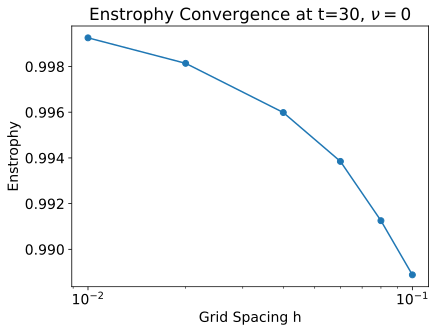

In [26]:
enstrophy0 = np.array([0.9888827150932382, 0.9912532570100147, 0.9938468751805953, 0.9959855540556799, 0.9981382203626138, 0.9992538843635116])
h = np.array([0.1, 0.08, 0.06, 0.04, 0.02, 0.01])
plt.plot(h, enstrophy0, '-o')
plt.xlabel('Grid Spacing h')
plt.ylabel("Enstrophy")
plt.title(r'Enstrophy Convergence at t=30, $\nu=0$')
plt.xscale('log')
#plt.yscale('log')
plt.savefig('enstrophy.pdf', bbox_inches='tight')

plt.show()


In [25]:
np.log((1-enstrophy0[-2])/(1-enstrophy0[-3]))/np.log((1-enstrophy0[-3])/(1-enstrophy0[-4]))

1.7991973861698634